# Implement micrograd step by step

The [micrograd](https://github.com/karpathy/micrograd) is a tiny autograd engine that implements backpropagation over a small neural network.

Backpropagation is an algorithm that allows you to efficiently evaluate the gradients of some kind of loss function with respect to the weights of the neural network. It allows us to iteratively tune the weights of that neural network to minimize the loss function and therefore improve the accuracy of the network.

So backprop is at the mathematical core of any modern deep neural network library like pytorch and jax.

In [2]:
# import standard packages
import numpy as np
import pandas as pd
import torch as tensor
import matplotlib.pyplot as plt
%matplotlib inline

First of all we want to understand what derivative is and exactly what information it gives us. 

Define a scalar valued function.

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

Plot the function to get sense of its shape

In [5]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [6]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

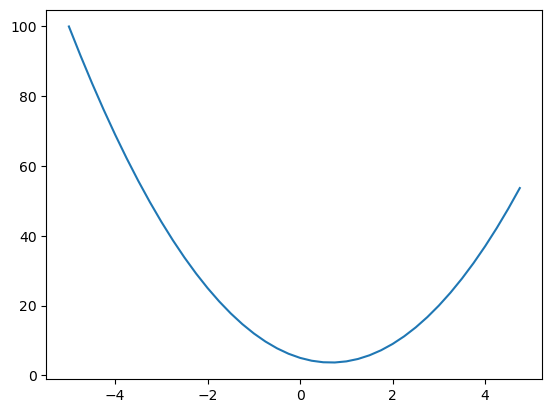

In [7]:
plt.plot(xs, ys)

What is the derivative of this function at any single input point x?

${\displaystyle L=\lim _{h\to 0}{\frac {f(a+h)-f(a)}{h}}}$

☝🏻 The definition is saying that if you slightly bump-up/increase the input x, how does the function responds or with what sensitivity the function respond or what is the slope at that point? Does the function go up or down and by how much?

In [8]:
# evaluate derivative

h = 0.001
x = 3.0

# we normalize by the run (i.e h) so that we have the rise over run to get the slope at 3.0
(f(x + h) - f(x)) / h

# if we increase the x positively, the function will respond positively
# also this is just the numerical approximation of the slope

# if we make h = 0.000000000000000000001, we will get an incorrect answer because the representation of these floating point numbers
# is finite in the computer memory

14.00300000000243

In [9]:
h = 0.00000001
x = -3.0
(f(x + h) - f(x)) / h

# at -3.0, if we slightly go in positive direction, the function will actually go down, that means the slope is going to be negative

-22.00000039920269

When the slope is zero, at that point if we nudge the input slightly, the functions does not change and stays the same almost

In [10]:
# les get more complex

a = 2.0
b = -3.0
c = 10.0

d = a * b + c

print(d)

4.0


Evaluate the derivative of d w.r.t a, b and c

In [11]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c

a += h

d2 = a * b + c

# if you think intuitively, we are adding h to a and b is a negative number. So we are adding less to d. 
# thus the value of function goes down.
print('d1', d1)
print('')
print('d2', d2)

# d2- d1 is how much the function increased when we bumped the value of a by h
# we then normalize it by h to get slope
print('')
print('slope', (d2 - d1)/h)

d1 4.0

d2 3.999699999999999

slope -3.000000000010772


Mathematically and analytically -3.0 is the right anwser because differentiating a * b + c by a will gives us just b (i.e. -3.0)

If we do this with b, the value should be similar to a

Neural networks are these massive mathematical expressions. We need a data structure to maintain these expressions.

In [12]:
class Value:
    
    def __init__(self, data):
        self.data = data
        
    # python internally uses __repr__ to return/print
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # add two Value objects
    # python internally calls a.__add__(b) when we do a + b
    def __add__(self, other):
        out = Value(self.data + other.data)
        return out
    
    # multiply two Value objects
    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out
    
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

a * b + c # a.__mul__(b).__add__(c)

Value(data=4.0)

We need to keep track/pointer of which values created which other values. So we are introducing *_children* which is a tuple. He did it for efficiency. We also want to know which operation created the value. We are maintaining this info in *_op*. We are adding labels as well.

In [13]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children) # we are maintaining it in a set
        self._op = _op
        self.label = label
        
    # python internally uses __repr__ to return/print
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # add two Value objects
    # python internally calls a.__add__(b) when we do a + b
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    # multiply two Value objects
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a * b; e.label = 'e'
d = e + c; d.label = 'd'

f = Value(-2.0, label='f')

L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [14]:
# e was created by d and c
e._prev

{Value(data=-3.0), Value(data=2.0)}

In [15]:
e._op

'*'

Visualize these expressions using graphviz

In [3]:
from graphviz import Digraph

def trace(root):
    
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        
        # for any value in the graph, create a rectangle {'record'} node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
        
        # build fake nodes to visualize the operation
        if n._op:
            # if this value is the result of some operation, create a node for it
            dot.node(name = uid + n._op, label = n._op)
            
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op nodes of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

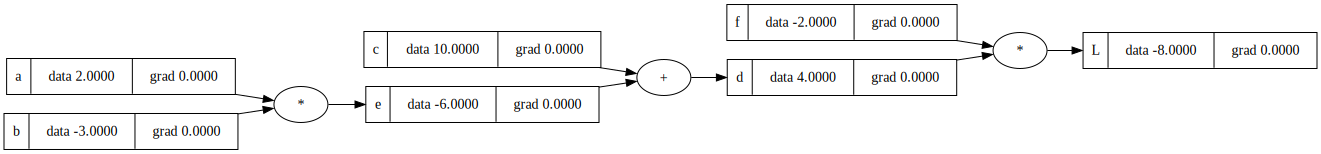

In [19]:
draw_dot(L)

Takeaways:

We are building mathematical expressions using + and * so far
They are scaler values
We are do forward pass that produces single output

Next we are going to run backpropagation. We will start at L and calculate the gradients at all the other nodes. We are basically calculating derivative of L w.r.t all the other nodes.

We want to know how these weights (i.e lead nodes) are impacting the nueral network. 

We do not use derivative of loss function w.r.t data as data is fixed but the weights will be iterated on.

We are adding a new variable called *grad*

In [38]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # by deafult it has no effect - at initialization we are assuming that these values does not affect the output
        self._prev = set(_children) # we are maintaining it in a set
        self._op = _op
        self.label = label
        
    # python internally uses __repr__ to return/print
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # add two Value objects
    # python internally calls a.__add__(b) when we do a + b
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    # multiply two Value objects
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a * b; e.label = 'e'
d = e + c; d.label = 'd'

f = Value(-2.0, label='f')

L = d * f; L.label = 'L'
L

Value(data=-8.0)

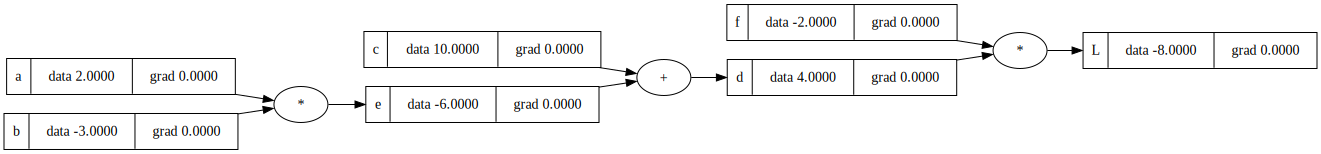

In [20]:
draw_dot(L)

Manual backpropagation - Let's calculate the gradient of L w.r.t all the other nodes and fill those values

In [35]:
# we are doing an inline gradient check

def lol():
    # creating a function does not mess up the global scope and these variables remain under local scope
    
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')

    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'

    f = Value(-2.0, label='f')

    L = d * f; L.label = 'L'
    L1 = L.data # Value node
    
    
    a = Value(2.0 + h, label='a') # adding h to a
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')

    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'

    f = Value(-2.0, label='f')

    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2 - L1)/h)

lol()

# similarly we can calculate gradients simply by adding h to each one of them

6.000000000000227


In [39]:
# Manually we are setting gradient of L to 1.0
L.grad = 1.0

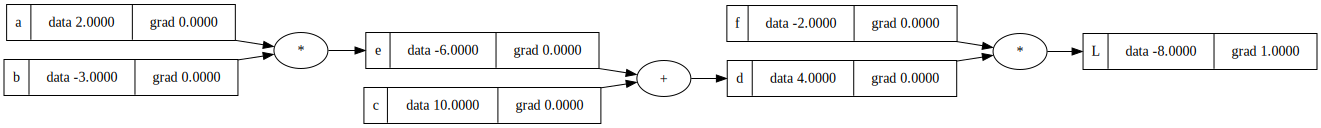

In [40]:
draw_dot(L)

In [24]:
# calculate derivative of L w.r.t d
# L = d * f
# dL/dd =? f

# proof
# ((d + h) * f - (d * f)) / h
# d * f + h * f - d * f / h
# h * f / h
# f

# similarly derivative of L w.r.t f will be equal to d

In [41]:
f.grad = 4.0
d.grad = -2.0

Gradient for this node is the most important as it involves chain rule from calculus.

Wikipedia - If a variable z depends on the variable y, which itself depends on the variable x (that is, y and z are dependent variables), then z depends on x as well, via the intermediate variable y. In this case, the chain rule is expressed as

${\displaystyle {\frac {dz}{dx}}={\frac {dz}{dy}}\cdot {\frac {dy}{dx}}}$

e.g. if a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man

In [42]:
# chain rule
# dL/dc = dL/dd * dd/dc

# d = c + e

# These are local derivatives
# dd/dc = 1.0
# dd/de = 1.0

# dL/dc = -2.0 * 1.0 = -2.0
# dL/de = -2.0 * 1.0 = -2.0

# + node literally just routes the gradients
# + node just distirbutes the derivatives to its children

In [43]:
c.grad = -2.0
e.grad = -2.0

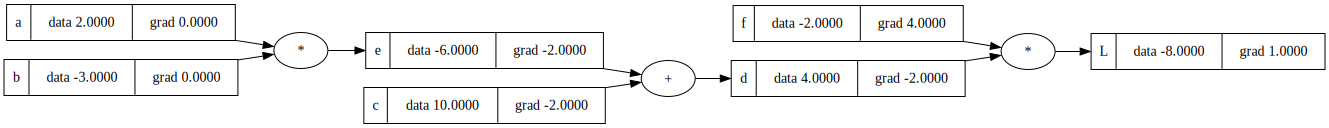

In [44]:
draw_dot(L)

In [45]:
# e = a * b
# dL/da = dL/de * de/da = -2.0 * -3.0 = 6.0
# dL/db = -2.0 * 2.0 = -4.0

a.grad = 6.0
b.grad = -4.0

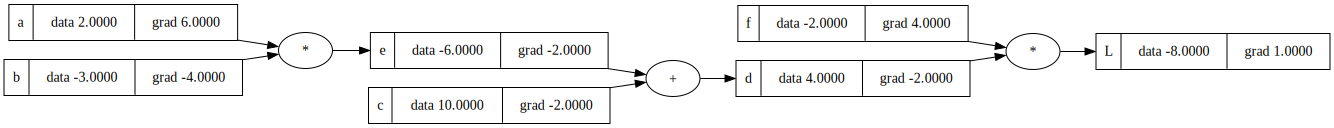

In [46]:
draw_dot(L)

Takeaways:
We iterate one by one through each node and apply chain rule locally. So backprop is just the recursive application of chain rule backwards through the computation graph.

In [48]:
# If we want to make L (loss) go down we are nudging the values in a positive direction
# We usually have control over the leaf nodes
# This is 1 step of the optimization process

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# forward pass
e = a * b
d = e + c
L = d * f

print(L.data)

-6.586368000000001


## Neural Networks

This is a MLP with 2 hidden layers. Inputs are many *WX* flowing into the cell body. There is also bias, which is kind of a trigger happiness of the neuron. It can make it more/less trigger happy depending on the input. We take the sum of wx of all the inputs, add the bias and then we take it thorugh an activation function. This activation funciton is like a squashing function like sigmoid or tanh. 

![MLP](https://cs231n.github.io/assets/nn1/neural_net2.jpeg)

![Neuron](https://cs231n.github.io/assets/nn1/neuron_model.jpeg)

tanh function - inputs that come in get squashed. Inputs only go to 1 or -1 and then becomes plateau. So if we pass very positive values, then we are gonna cap it smoothly at 1 and at negative side we are gonna cap it smoothly to -1

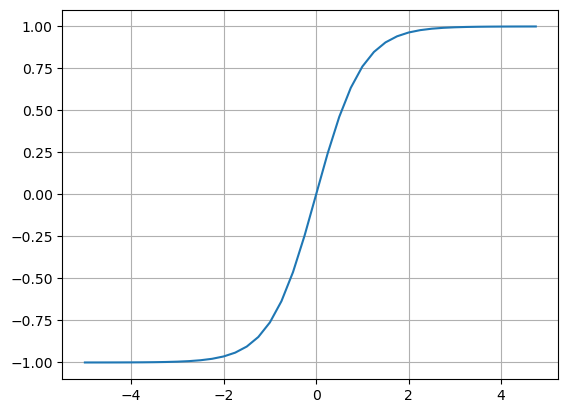

In [49]:
plt.plot(np.arange(-5, 5, 0.25), np.tanh(np.arange(-5, 5, 0.25))); plt.grid();

Then at the output is the activation function applied to the dot product of the weights w and the input x and bias

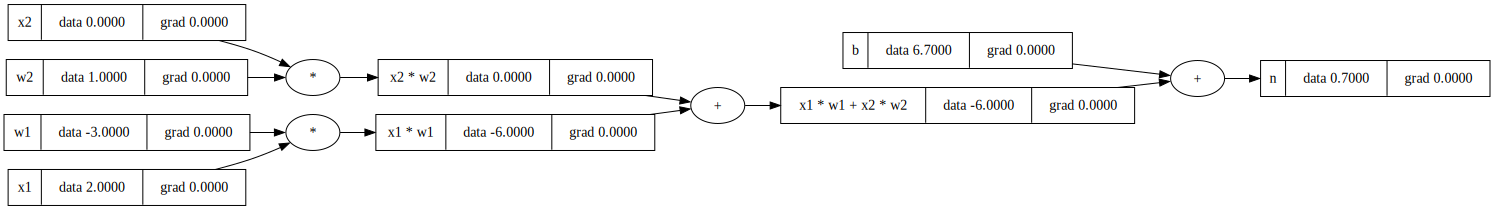

In [50]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2 - synaptic strength for each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.7, label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1 * w1'
x2w2 = x2 * w2; x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1 * w1 + x2 * w2'
n = x1w1x2w2 + b; n.label = 'n'

# we need to add tanh() in the Value class because tanh is an hyperbolic function and cannot be defined using only + and *
# it needs exponention
o = n.tanh() 
draw_dot(n)

In [4]:
import math

class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # by deafult it has no effect - at initialization we are assuming that these values does not affect the output
        self._prev = set(_children) # we are maintaining it in a set
        self._op = _op
        self.label = label
        
    # python internally uses __repr__ to return/print
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # add two Value objects
    # python internally calls a.__add__(b) when we do a + b
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    # multiply two Value objects
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    # we can create simple/complex functions. Its totally upto us.
    # we should just be able to deferentiate the function
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1)/(math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')
        return out
    
    
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2 - synaptic strength for each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b') # used this bias to make the number come out nice 
 
# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1 * w1'
x2w2 = x2 * w2; x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1 * w1 + x2 * w2'
n = x1w1x2w2 + b; n.label = 'n'

# we need to add tanh() in the Value class because tanh is an hyperbolic function and cannot be defined using only + and *
# it needs exponention
o = n.tanh(); o.label = 'o'

## Manual Backpropagation

We are going to fill in all the gradients

Typically in the neural network settings we care about the gradients of the weights (w1, w2)

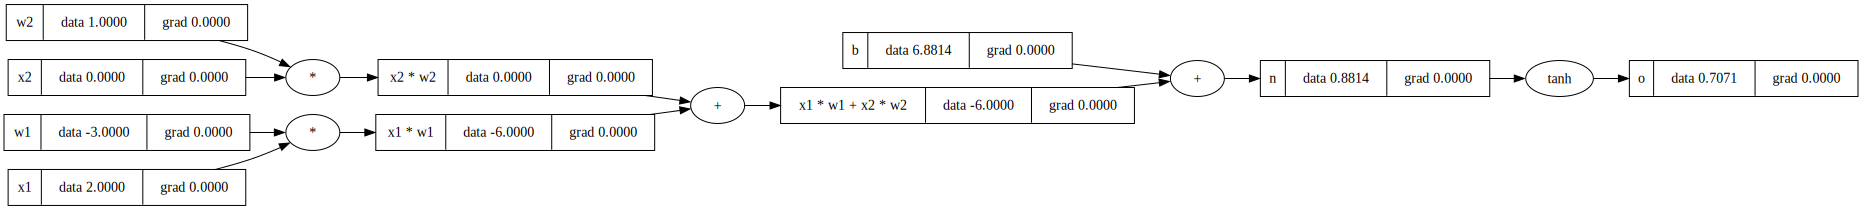

In [5]:
draw_dot(o)

In [6]:
o.grad = 1.0

Now to backpropagate through tanh we need to know the local derivative of tanh

In [7]:
# o = tanh(n)
# do/dn = 1 - tanh(n) ** 2 = 1 - o ** 2

# n.grad = 1 - o.data ** 2
n.grad = 0.5

In [8]:
# + is just a distributor of the gradient
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [9]:
# again there is a + and the gradient will just flow through
x1w1.grad = 0.5
x2w2.grad = 0.5

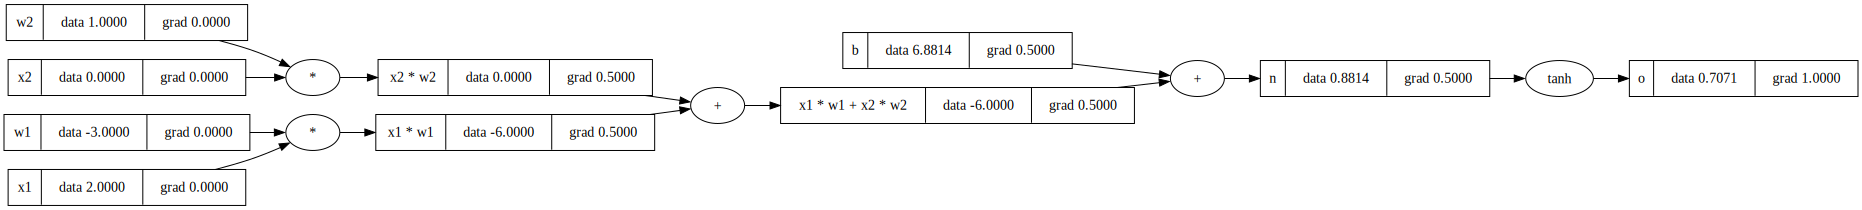

In [10]:
draw_dot(o)

In [11]:
# now there is a multiplication operator so we know that the gradient will be the other term
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

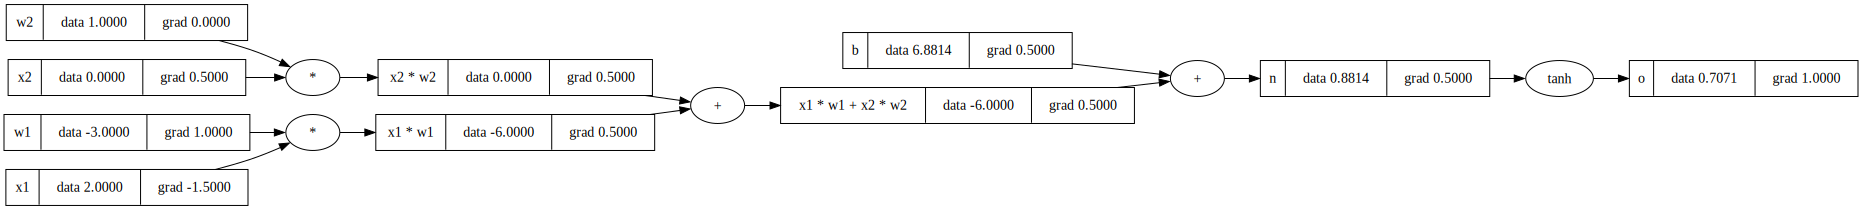

In [12]:
draw_dot(o)

w2 gradient is 0.0 and if you think about it intuitively, derivative always tells you about how the value is going to influence the output. If I wiggle w2, how is the output changing? Its not changing because we are multiplying by x2.data = 0.0 and as it is not changing there is no derivative and 0.0 is the anwser

w2 does not matter to this neuron so if you want to increase the output, value of w1 should be increased

## Automatic Backpropagation

In [20]:
import math

class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # by deafult it has no effect - at initialization we are assuming that these values does not affect the output
        self._backward = lambda: None # empty function. for example, for a leaf node there is nothing to do
        self._prev = set(_children) # we are maintaining it in a set
        self._op = _op
        self.label = label
        
    # python internally uses __repr__ to return/print
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # add two Value objects
    # python internally calls a.__add__(b) when we do a + b
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    # multiply two Value objects
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        
        return out
    
    # we can create simple/complex functions. Its totally upto us.
    # we should just be able to deferentiate the function
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1)/(math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad = (1 - t ** 2) * out.grad
        out._backward = _backward
        
        return out
    
    
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2 - synaptic strength for each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b') # used this bias to make the number come out nice 
 
# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1 * w1'
x2w2 = x2 * w2; x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1 * w1 + x2 * w2'
n = x1w1x2w2 + b; n.label = 'n'

# we need to add tanh() in the Value class because tanh is an hyperbolic function and cannot be defined using only + and *
# it needs exponention
o = n.tanh(); o.label = 'o'

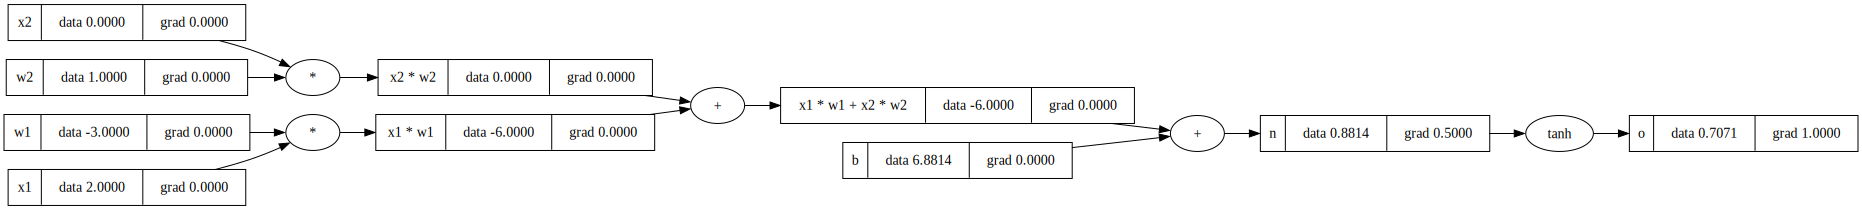

In [15]:
# we are going through tanh first but the out.grad is 0.0 as we have set the initial grad to 0.0 
# so we have to write a base case first
o.grad = 1.0

o._backward()
draw_dot(o)

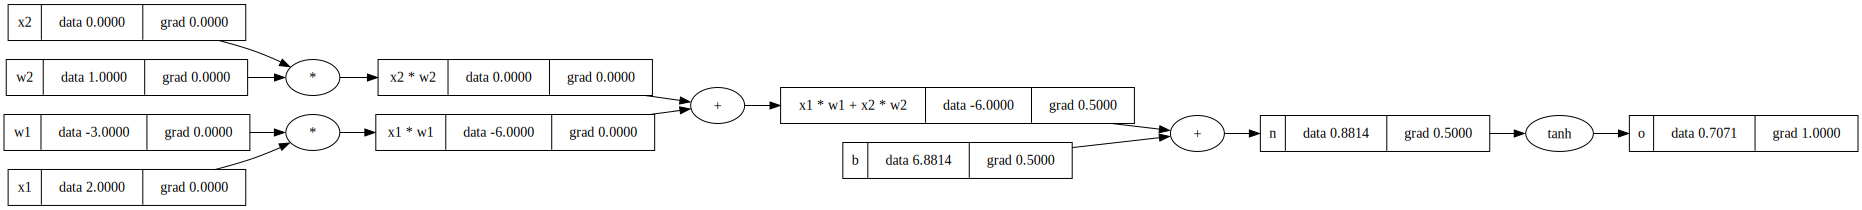

In [16]:
n._backward()
draw_dot(o)

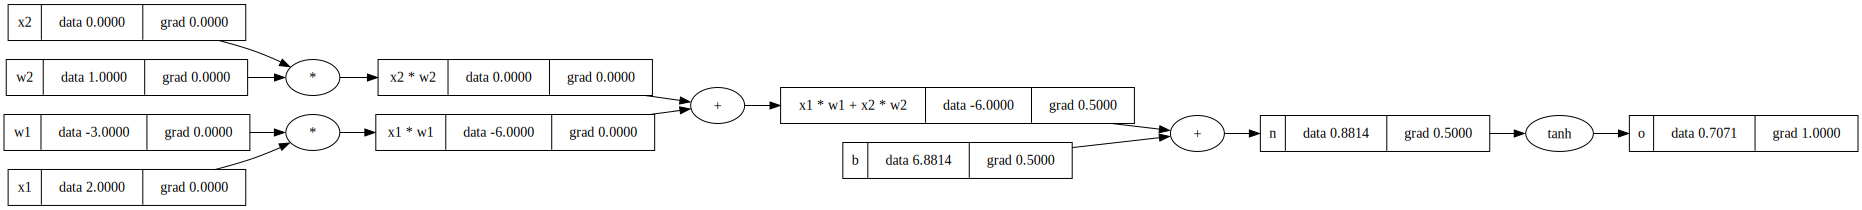

In [18]:
# b is a leaf node and by definition its backward is an empty function
b._backward()
draw_dot(o)

Now we want to stop manually calling the _backward() like we are calling now one after another backwards on our nodes


Now in order to do automatic backprop we need to have all the dependencies calculated before we can continue. This ordering of the nodes can be achieved by topological sort.

![Topological sort](https://i.imgur.com/Q3MA6dZ.png)

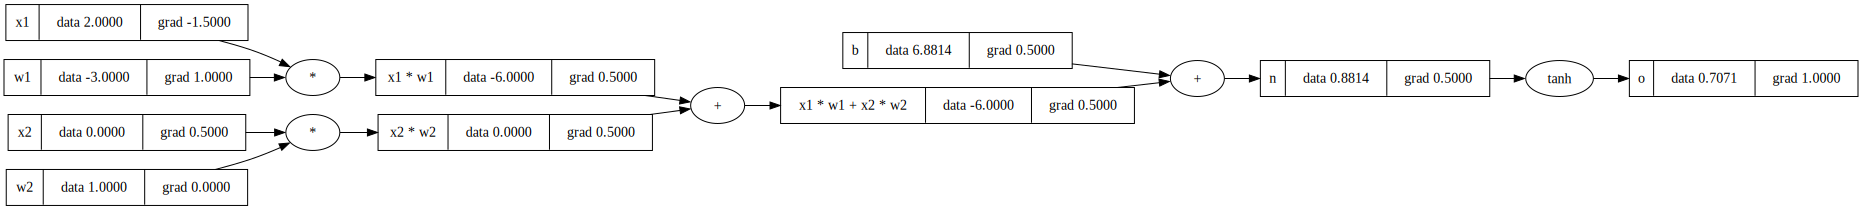

In [21]:
o.grad = 1.0

# this builds a topological graph
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()
    
draw_dot(o)

We will add the logic in the Value class

In [22]:
import math

class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # by deafult it has no effect - at initialization we are assuming that these values does not affect the output
        self._backward = lambda: None # empty function. for example, for a leaf node there is nothing to do
        self._prev = set(_children) # we are maintaining it in a set
        self._op = _op
        self.label = label
        
    # python internally uses __repr__ to return/print
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # add two Value objects
    # python internally calls a.__add__(b) when we do a + b
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    # multiply two Value objects
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        
        return out
    
    # we can create simple/complex functions. Its totally upto us.
    # we should just be able to deferentiate the function
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1)/(math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad = (1 - t ** 2) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        
        # builds a topological graph
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2 - synaptic strength for each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b') # used this bias to make the number come out nice 
 
# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1 * w1'
x2w2 = x2 * w2; x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1 * w1 + x2 * w2'
n = x1w1x2w2 + b; n.label = 'n'

# we need to add tanh() in the Value class because tanh is an hyperbolic function and cannot be defined using only + and *
# it needs exponention
o = n.tanh(); o.label = 'o'

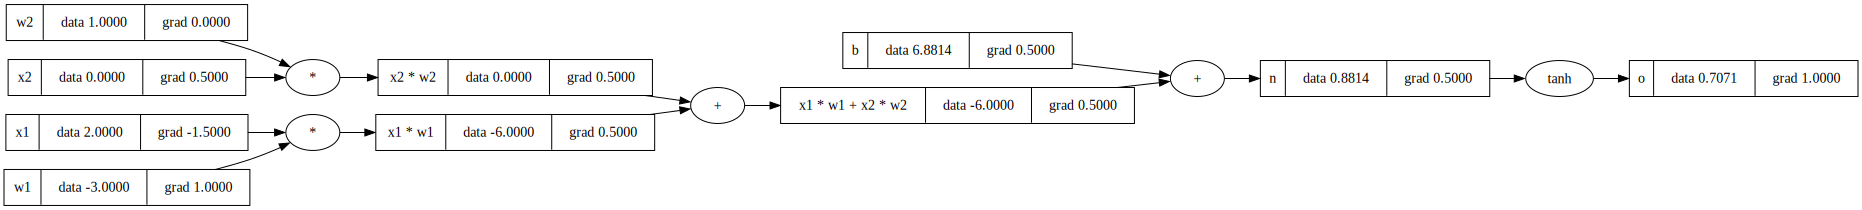

In [23]:
o.backward()
draw_dot(o)

There is a bug in the code.

If you can see the derivative of b w.r.t a should be 2 (a + a = 2 * a = 2)

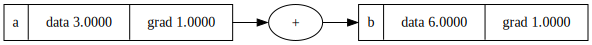

In [24]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

Similarly the derivative of a and b gets calculated when we do e.backward() and gets overwritten when we do d.backward(). This happens when we have same variable more than once.

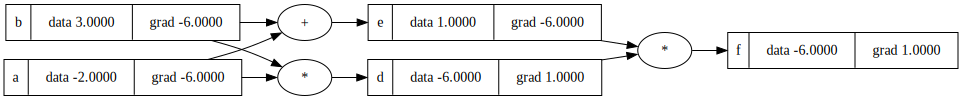

In [25]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label='d'
e = a + b; e.label='e'
f = d * e; f.label='f'

f.backward()
draw_dot(f)

Solution to this problem is to accumulate these gradients

In [67]:
import math

class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # by deafult it has no effect - at initialization we are assuming that these values does not affect the output
        self._backward = lambda: None # empty function. for example, for a leaf node there is nothing to do
        self._prev = set(_children) # we are maintaining it in a set
        self._op = _op
        self.label = label
        
        
    # python internally uses __repr__ to return/print
    def __repr__(self):
        return f"Value(data={self.data})"
    
    
    def __radd__(self, other):
        return self + other
    
    
    # add two Value objects
    # python internally calls a.__add__(b) when we do a + b
    def __add__(self, other):
        # if the other is not an Value convert it to Value
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    
    def __neg__(self):
        return self * -1
    
    
    def __sub__(self, other):
        return self + (-other)
    
    
    # fallback. If we are doing 2 * a, python will check if a * 2 is possible and that will be called in __rmul__
    def __rmul__(self, other):
        return self * other
        
    
    # multiply two Value objects
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    
    # power
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting in/float powers (for now)"
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        
        out._backward = _backward
        return out
    
    
    # division
    def __truediv__(self, other):
        return self * (other ** -1)
    
    
    # we can create simple/complex functions. Its totally upto us.
    # we should just be able to deferentiate the function
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1)/(math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        
        return out
    
    
    # exponentiation
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
    
        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward
        return out
    
    def backward(self):
        
        # builds a topological graph
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

This works perfectly now as we are accumulating the gradients

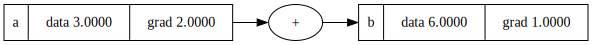

In [27]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [31]:
# We cannot do as we only have addition for Value object
# a = Value(2.0)

# a + 1

# 2 * a

Value(data=3.0)

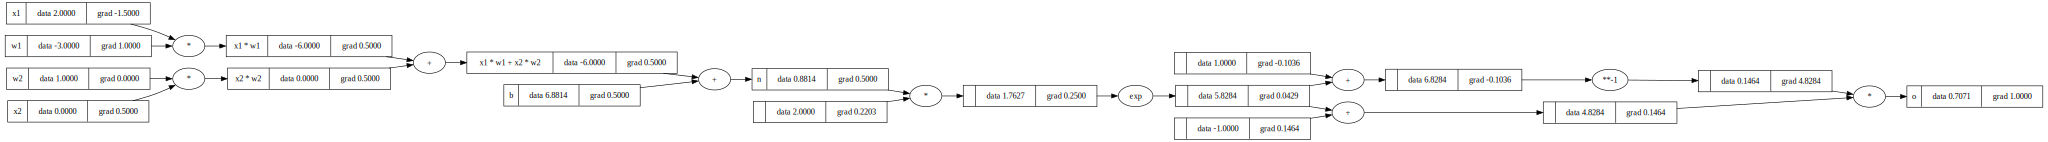

In [34]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2 - synaptic strength for each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b') # used this bias to make the number come out nice 
 
# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1 * w1'
x2w2 = x2 * w2; x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1 * w1 + x2 * w2'
n = x1w1x2w2 + b; n.label = 'n'

# ---
e = (2 * n).exp()
o = (e - 1) / (e + 1)
# ---

o.label = 'o'
o.backward()
draw_dot(o)

We will do the exact same thing using pytorch api. The difference between micrograd and pytorch is that micrograd is a scalar value engine. In pytorch everything is based on tensor (multi-dimensional arrays)

In [35]:
import torch

x1 = torch.Tensor([2.0]).double();  x1.requires_grad = True  # these are single element tensors
x2 = torch.Tensor([0.0]).double();  x2.requires_grad = True  # we are casting the tensor dataatype to double as python uses float64
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True  # default dataatype of tensors is float32
w2 = torch.Tensor([1.0]).double();  w2.requires_grad = True  # after casting its dtype is float64 aka double
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True 

# these are leaf nodes. so pytorch assumes that we do not need gradients. we need to explicitly tell that all these nodes requires gradients

n = x1*w1 + x2*w2 + b # perform arithmetic just like with micrograd
o = torch.tanh(n)

print(o.data.item()) # item() gets the value from the tensor
o.backward() # backward() is pytorch's autograd function

print('---') # These values below are just like micrograds left most layer
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [36]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [37]:
o.item()

0.7071066904050358

Using tensors we can do operations in parallel

We are going to build neural network using pytorch api

## Neuron

In [47]:
import random

In [73]:
class Neuron:
    
    # nin : number of inputs to the neuron
    # random weight (-1, 1) per input
    # random bias that controls the trigger happiness of the neuron
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    # x = [1.0, 2.0]
    # n = Nueron(2)
    # n(x)
    # this triggers __call__
    def __call__(self, x):
        # w * x + b
        # zip takes 2 iterators and then it creates a new iterator that iterates over the tuple of the corresponding entries
        # generator expr sum((expr), 0.0) must be parenthesized
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b) # um take one more arg. default start is 0.0 but we cann start at selsf.b 
        # squashing function
        out = act.tanh()
        return out
    
    # convenience code to gather all the parameters and then we can nudge them slightly 
    # pytorch has a parameters on every module
    def parameters(self):
        return self.w + [self.b]

## Layer

In [74]:
class Layer:
    
    # nin: number of nuerons in a layer
    # nouts: number of inputs per neuron
    def __init__(self, nin, nout):
        # creates a list of neurons
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
#         params = []
#         for neuron in self.neurons:
#             ps = neuron.parameters()
#             params.extend(ps)
#         return params

## MLP

In [75]:
class MLP:
    
    # nin: number of inputs to the nn
    # nouts: number of layers
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [99]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.6211349986885816)

Let's now create a small dataset

In [100]:
# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

# desired targets
ys = [1.0, -1.0, -1.0, 1.0]

In [101]:
ypred

[Value(data=0.9874187867551947),
 Value(data=-0.9999516070469668),
 Value(data=-0.9999348663606606),
 Value(data=0.9875140738471031)]

So for the first value its -0.87 and our desired target is 1.0. So we want it to be higher.

So how do we tune the weights of the neural network to better predict the desired targets?

Trick is to calculate a single number that measures the preformance of the neural network. It is called as Loss.

So in this case the nn is not performing well and so the loss is high and we need to minimize the loss.

In [88]:
# the greater the off we are, the higher the loss will be
# so we want lower loss
# mean squared error loss
# we need __radd__ for this to work because ys are ints and ypred are Value so python does not know how to add int with Value

ypred = [n(x) for x in xs]

loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

loss

Value(data=4.87316559918176)

In [90]:
loss.backward()

In [89]:
n.layers[0].neurons[0].w[0].grad

0.2969890132610222

In [83]:
n.layers[0].neurons[0].w[0].data

-0.9142973221950783

Gradients of input data is not useful as input data is not changing. Basically we want to decrease the loss. But the direction of the gradient vector is in the increasing the loss. So we want to (-) the loss.

If you take a big step size, it may overstep or get overconfident

In [91]:
for p in n.parameters():
    p.data += -0.01 * p.grad

So if we nudge all the parameters by tiny amount 

In [85]:
n.layers[0].neurons[0].w[0].data

-0.9172672123276885

## Gradient Dissent

We iteratively do forward pass, backward pass, update

In [102]:
for k in range(30):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # stochastic gradient dissent update
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(k, loss.data)

0 5.489635441323987
1 4.152382222919246
2 3.1554164132075897
3 2.3914106673413515
4 1.8780893178158562
5 1.4941745043578245
6 1.1641867995469803
7 0.7314779295016773
8 0.4688639981897258
9 0.35246799488484926
10 0.28970014919471504
11 0.24401236756880212
12 0.20963455815612858
13 0.18305265629286033
14 0.16200758439560917
15 0.14500383849040038
16 0.13102271893762452
17 0.11935163300039722
18 0.10947992548346665
19 0.10103360580005133
20 0.0937333744177071
21 0.08736696296162953
22 0.0817704876491631
23 0.07681561305627002
24 0.07240054441772195
25 0.06844359440990942
26 0.06487851395367064
27 0.06165105284399523
28 0.058716391606086035
29 0.056037199726558656


In [103]:
ypred

[Value(data=0.9062938421558614),
 Value(data=-0.8619675623008356),
 Value(data=-0.8976592934298013),
 Value(data=0.8668467738648934)]

https://twitter.com/karpathy/status/1013244313327681536?lang=en

You forgot to zero_grad() before backward()

When we do updates on the parameter we are not flushing the already accumulated gradients

they are not getting reset

it only worked because this is a very simple network and its easy to fit this data

the accumulated gradients gave us a larger step size and we converged very fast

after fixing the bug, we need to do more iterations to get to the min loss

## Recap

What are neural nets? 
mathematical expression that take input as data and they take input weights and parameters of the nn
mathematical expr for the forward pass
followd by a loss function and loss measures the accuracy of the predictions
typically loss is low when your predictions are matching the desired targets
and network is behaving well
we manipulate the loss because when loss is low the network is doing what you wanted

then we backward the loss
use backprop to get gradients

then we know how to tune the parameters to decrease the loss locally

then we need to do this process iteratively and this is called gradient dissent
we follow the gradient info that sort of minimizes the loss

## The actual engine.py from micrograd

In [ ]:

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

## The actual nn.py from micrograd

In [ ]:
import random
from micrograd.engine import Value

class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

## The test_engine.py from micrograd

In [ ]:
import torch
from micrograd.engine import Value

def test_sanity_check():

    x = Value(-4.0)
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xmg, ymg = x, y

    x = torch.Tensor([-4.0]).double()
    x.requires_grad = True
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xpt, ypt = x, y

    # forward pass went well
    assert ymg.data == ypt.data.item()
    # backward pass went well
    assert xmg.grad == xpt.grad.item()

def test_more_ops():

    a = Value(-4.0)
    b = Value(2.0)
    c = a + b
    d = a * b + b**3
    c += c + 1
    c += 1 + c + (-a)
    d += d * 2 + (b + a).relu()
    d += 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g += 10.0 / f
    g.backward()
    amg, bmg, gmg = a, b, g

    a = torch.Tensor([-4.0]).double()
    b = torch.Tensor([2.0]).double()
    a.requires_grad = True
    b.requires_grad = True
    c = a + b
    d = a * b + b**3
    c = c + c + 1
    c = c + 1 + c + (-a)
    d = d + d * 2 + (b + a).relu()
    d = d + 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g = g + 10.0 / f
    g.backward()
    apt, bpt, gpt = a, b, g

    tol = 1e-6
    # forward pass went well
    assert abs(gmg.data - gpt.data.item()) < tol
    # backward pass went well
    assert abs(amg.grad - apt.grad.item()) < tol
    assert abs(bmg.grad - bpt.grad.item()) < tol

Andrej has used svm "max-margin" loss in the demo.ipynb and relu as activation function